In [1]:
import os


In [2]:
from __future__ import print_function
from keras import backend as K
from keras.layers import Layer
from keras import activations
from keras import utils
from keras.datasets import fashion_mnist
from keras.datasets import mnist
from keras.models import Model
from keras.layers import *
from keras.preprocessing.image import ImageDataGenerator
import cv2

Using TensorFlow backend.
C:\Users\ASUS\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\ASUS\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\ASUS\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\ASUS\Anaconda3

In [3]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [4]:
Vld_Splt= 0.0909
batch_size = 200
num_classes = 10
epochs = 30

In [5]:
from keras.utils import np_utils

'''LOAD DATA'''
Dir= 'C:/pythonwork/MHDD/'
x_train= np.load(Dir+'HMDD_Train_X.npy')
y_train=np.load(Dir+'HMDD_Train_Y.npy')
x_test=np.load(Dir+'HMDD_Test_X.npy')
y_test=np.load(Dir+'HMDD_Test_Y.npy')

'''PRE-PROCESSING'''
x_train = x_train.reshape(-1, 28, 28, 1).astype('float32') / 255.
x_test = x_test.reshape(-1, 28, 28, 1).astype('float32') / 255.
# n_Vld= int(np.floor(Vld_Splt* x_train.shape[0]))  # Num. of validation data

In [6]:
print('', x_train.shape,'\n',y_train.shape,'\n',x_test.shape,'\n',y_test.shape,'\n')

 (60000, 28, 28, 1) 
 (60000, 10) 
 (10000, 28, 28, 1) 
 (10000, 10) 



In [7]:
# the squashing function.
# we use 0.5 in stead of 1 in hinton's paper.
# if 1, the norm of vector will be zoomed out.
# if 0.5, the norm will be zoomed in while original norm is less than 0.5
# and be zoomed out while original norm is greater than 0.5.
def squash(x, axis=-1):
    s_squared_norm = K.sum(K.square(x), axis, keepdims=True) + K.epsilon()
    scale = K.sqrt(s_squared_norm) / (0.5 + s_squared_norm)
    return scale * x


# define our own softmax function instead of K.softmax
# because K.softmax can not specify axis.
def softmax(x, axis=-1):
    ex = K.exp(x - K.max(x, axis=axis, keepdims=True))
    return ex / K.sum(ex, axis=axis, keepdims=True)


# define the margin loss like hinge loss
def margin_loss(y_true, y_pred):
    lamb, margin = 0.5, 0.1
    return K.sum(y_true * K.square(K.relu(1 - margin - y_pred)) + lamb * (
        1 - y_true) * K.square(K.relu(y_pred - margin)), axis=-1)


class Capsule(Layer):
    """A Capsule Implement with Pure Keras
    There are two vesions of Capsule.
    One is like dense layer (for the fixed-shape input),
    and the other is like timedistributed dense (for various length input).

    The input shape of Capsule must be (batch_size,
                                        input_num_capsule,
                                        input_dim_capsule
                                       )
    and the output shape is (batch_size,
                             num_capsule,
                             dim_capsule
                            )

    Capsule Implement is from https://github.com/bojone/Capsule/
    Capsule Paper: https://arxiv.org/abs/1710.09829
    """

    def __init__(self,
                 num_capsule,
                 dim_capsule,
                 routings=3,
                 share_weights=True,
                 activation='squash',
                 **kwargs):
        super(Capsule, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_capsule = dim_capsule
        self.routings = routings
        self.share_weights = share_weights
        if activation == 'squash':
            self.activation = squash
        else:
            self.activation = activations.get(activation)

    def build(self, input_shape):
        input_dim_capsule = input_shape[-1]
        if self.share_weights:
            self.kernel = self.add_weight(
                name='capsule_kernel',
                shape=(1, input_dim_capsule,
                       self.num_capsule * self.dim_capsule),
                initializer='glorot_uniform',
                trainable=True)
        else:
            input_num_capsule = input_shape[-2]
            self.kernel = self.add_weight(
                name='capsule_kernel',
                shape=(input_num_capsule, input_dim_capsule,
                       self.num_capsule * self.dim_capsule),
                initializer='glorot_uniform',
                trainable=True)

    def call(self, inputs):
        """Following the routing algorithm from Hinton's paper,
        but replace b = b + <u,v> with b = <u,v>.

        This change can improve the feature representation of Capsule.

        However, you can replace
            b = K.batch_dot(outputs, hat_inputs, [2, 3])
        with
            b += K.batch_dot(outputs, hat_inputs, [2, 3])
        to realize a standard routing.
        """

        if self.share_weights:
            hat_inputs = K.conv1d(inputs, self.kernel)
        else:
            hat_inputs = K.local_conv1d(inputs, self.kernel, [1], [1])

        batch_size = K.shape(inputs)[0]
        input_num_capsule = K.shape(inputs)[1]
        hat_inputs = K.reshape(hat_inputs,
                               (batch_size, input_num_capsule,
                                self.num_capsule, self.dim_capsule))
        hat_inputs = K.permute_dimensions(hat_inputs, (0, 2, 1, 3))

        b = K.zeros_like(hat_inputs[:, :, :, 0])
        for i in range(self.routings):
            c = softmax(b, 1)
            o = self.activation(K.batch_dot(c, hat_inputs, [2, 2]))
            if i < self.routings - 1:
                b = K.batch_dot(o, hat_inputs, [2, 3])
                if K.backend() == 'theano':
                    o = K.sum(o, axis=1)

        return o

    def compute_output_shape(self, input_shape):
        return (None, self.num_capsule, self.dim_capsule)

In [8]:
"""one-CONV-LAYERS-THICK"""
input_image = Input(shape=(x_train.shape[1], x_train.shape[2], x_train.shape[3]))
x_0 = Conv2D(filters= 250, kernel_size= 7, activation='relu', 
             padding= 'valid')(input_image)
x_0= Dropout(0.1)(x_0)


"""now we reshape it as (batch_size, input_num_capsule, input_dim_capsule)
then connect a Capsule layer.

the output of final model is the lengths of 10 Capsule, whose dim=16.

the length of Capsule is the proba,
so the problem becomes a 10 two-classification problem.
"""

x_0 = Reshape((-1, 250))(x_0)
capsule_0 = Capsule(num_classes, 16, 3, True)(x_0)
output_0 = Lambda(lambda z: K.sqrt(K.sum(K.square(z), 2)))(capsule_0)
model_0 = Model(inputs= input_image, outputs= output_0)

# we use a margin loss
model_0.compile(loss =margin_loss, optimizer='adam', metrics=['accuracy'])
model_0.summary()

# we can compare the performance with or without data augmentation
data_augmentation = False

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 22, 22, 250)       12500     
_________________________________________________________________
dropout_1 (Dropout)          (None, 22, 22, 250)       0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 484, 250)          0         
_________________________________________________________________
capsule_1 (Capsule)          (None, 10, 16)            40000     
_________________________________________________________________
lambda_1 (Lambda)    

In [9]:
"""two-CONV-LAYERS-THICK"""
input_image = Input(shape=(x_train.shape[1], x_train.shape[2], x_train.shape[3]))
x_1 = Conv2D(filters= 15, kernel_size= 7, activation='relu', 
             padding= 'valid')(input_image)
x_1= Dropout(0.1)(x_1)
x_1 = Conv2D(filters= 60, kernel_size= 7, activation='relu',
             strides= 1)(x_1)
x_1 = Dropout(0.1)(x_1)


"""now we reshape it as (batch_size, input_num_capsule, input_dim_capsule)
then connect a Capsule layer.

the output of final model is the lengths of 10 Capsule, whose dim=16.

the length of Capsule is the proba,
so the problem becomes a 10 two-classification problem.
"""

x_1 = Reshape((-1, 60))(x_1)
capsule_1 = Capsule(num_classes, 16, 3, True)(x_1)
output_1 = Lambda(lambda z: K.sqrt(K.sum(K.square(z), 2)))(capsule_1)
model_1= Model(inputs= input_image, outputs= output_1)

# we use a margin loss
model_1.compile(loss =margin_loss, optimizer='adam', metrics=['accuracy'])
model_1.summary()

# we can compare the performance with or without data augmentation
data_augmentation = False

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 22, 22, 15)        750       
_________________________________________________________________
dropout_2 (Dropout)          (None, 22, 22, 15)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 60)        44160     
_________________________________________________________________
dropout_3 (Dropout)          (None, 16, 16, 60)        0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 256, 60)           0         
_________________________________________________________________
capsule_2 (Capsule)          (None, 10, 16)            9600      
__________

In [54]:
"""three-CONV-LAYERS-THICK"""
input_image = Input(shape=(x_train.shape[1], x_train.shape[2], x_train.shape[3]))
x_2 = Conv2D(filters= 15, kernel_size= 7, activation='relu', 
             padding= 'valid')(input_image)
x_2= Dropout(0.1)(x_2)
x_2 = Conv2D(filters= 25, kernel_size= 7, activation='relu',
             strides= 1)(x_2)
x_2 = Dropout(0.1)(x_2)
x_2 = Conv2D(filters= 25, kernel_size= 7, activation='relu',
             strides= 1)(x_2)
x_2 = Dropout(0.1)(x_2)


"""now we reshape it as (batch_size, input_num_capsule, input_dim_capsule)
then connect a Capsule layer.

the output of final model is the lengths of 10 Capsule, whose dim=16.

the length of Capsule is the proba,
so the problem becomes a 10 two-classification problem.
"""

x_2 = Reshape((-1, 25))(x_2)
capsule_2 = Capsule(num_classes, 16, 3, True)(x_2)
output_2 = Lambda(lambda z: K.sqrt(K.sum(K.square(z), 2)))(capsule_2)
model_2= Model(inputs= input_image, outputs= output_2)

# we use a margin loss
model_2.compile(loss =margin_loss, optimizer='adam', metrics=['accuracy'])
model_2.summary()

# we can compare the performance with or without data augmentation
data_augmentation = False

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 22, 22, 15)        750       
_________________________________________________________________
dropout_39 (Dropout)         (None, 22, 22, 15)        0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 16, 16, 25)        18400     
_________________________________________________________________
dropout_40 (Dropout)         (None, 16, 16, 25)        0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 10, 10, 25)        30650     
_________________________________________________________________
dropout_41 (Dropout)         (None, 10, 10, 25)        0         
__________

In [56]:
"""four-CONV-LAYERS-THICK"""
input_image = Input(shape=(x_train.shape[1], x_train.shape[2], x_train.shape[3]))
x_3 = Conv2D(filters= 15, kernel_size= 7, activation='relu', 
             padding= 'valid')(input_image)
x_3= Dropout(0.1)(x_3)
x_3 = Conv2D(filters= 18 ,kernel_size= 7, activation='relu',
             strides= 1)(x_3)
x_3 = Dropout(0.1)(x_3)
x_3 = Conv2D(filters= 20, kernel_size= 7, activation='relu',
             strides= 1)(x_3)
x_3= Dropout(0.1)(x_3)
x_3 = Conv2D(filters= 25,kernel_size= 7, activation='relu',
             strides= 1)(x_3)
x_3= Dropout(0.1)(x_3)


"""now we reshape it as (batch_size, input_num_capsule, input_dim_capsule)
then connect a Capsule layer.

the output of final model is the lengths of 10 Capsule, whose dim=16.

the length of Capsule is the proba,
so the problem becomes a 10 two-classification problem.
"""

x_3 = Reshape((-1, 25))(x_3)
capsule_3 = Capsule(num_classes, 16, 3, True)(x_3)
output_3 = Lambda(lambda z: K.sqrt(K.sum(K.square(z), 2)))(capsule_3)
model_3= Model(inputs= input_image, outputs= output_3)

# we use a margin loss
model_3.compile(loss =margin_loss, optimizer='adam', metrics=['accuracy'])
model_3.summary()

# we can compare the performance with or without data augmentation
data_augmentation = False

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 22, 22, 15)        750       
_________________________________________________________________
dropout_46 (Dropout)         (None, 22, 22, 15)        0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 16, 16, 18)        13248     
_________________________________________________________________
dropout_47 (Dropout)         (None, 16, 16, 18)        0         
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 10, 10, 20)        17660     
_________________________________________________________________
dropout_48 (Dropout)         (None, 10, 10, 20)        0         
__________

In [12]:
"""CNN-3-CONV-LAYERS"""
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, \
                         ZeroPadding2D

model_4= Sequential()
model_4.add(Conv2D(filters= 5, kernel_size= (7, 7), padding= 'same', 
                   input_shape=(x_train.shape[1], x_train.shape[2], x_train.shape[3]), 
                   activation='relu'))
model_4.add(MaxPooling2D(pool_size=(2,2)))
model_4.add(Conv2D(filters= 10, kernel_size= (7, 7), 
                    padding= 'same', activation='relu'))
model_4.add(Dropout(0.4))
model_4.add(MaxPooling2D(pool_size=(2,2)))

model_4.add(Flatten())
model_4.add(Dropout(0.5))
model_4.add(Dense(256, activation='relu'))
model_4.add(Dense(num_classes, activation='softmax'))
print(model_4.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 28, 28, 5)         250       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 5)         0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 14, 14, 10)        2460      
_________________________________________________________________
dropout_11 (Dropout)         (None, 14, 14, 10)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 10)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 490)               0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 490)               0         
__________

In [13]:
"""one-CONV-LAYERS-THICK"""
if not data_augmentation:
    print('Not using data augmentation.')
    train_history_0= model_0.fit(
        x_train,
        y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_split= Vld_Splt,
        shuffle=True)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by dataset std
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in 0 to 180 degrees
        width_shift_range=0.1,  # randomly shift images horizontally
        height_shift_range=0.1,  # randomly shift images vertically
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    train_history_0= model_0.fit_generator(
        datagen.flow(x_train, y_train, batch_size=batch_size),
        epochs= epochs,
        validation_split= Vld_Splt,
        steps_per_epoch= int(x_train.shape[0]/ batch_size),
        workers=4)

Not using data augmentation.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 54546 samples, validate on 5454 samples
Epoch 1/30
54546/54546 [==============================] - 17s 305us/step - loss: 0.3759 - acc: 0.5755 - val_loss: 0.2710 - val_acc: 0.7539
Epoch 2/30
54546/54546 [==============================] - 14s 262us/step - loss: 0.2548 - acc: 0.7517 - val_loss: 0.2259 - val_acc: 0.7888
Epoch 3/30
54546/54546 [==============================] - 14s 263us/step - loss: 0.2220 - acc: 0.7895 - val_loss: 0.1988 - val_acc: 0.8289
Epoch 4/30
54546/54546 [==============================] - 14s 263us/step - loss: 0.2044 - acc: 0.8095 - val_loss: 0.1933 - val_acc: 0.8355
Epoch 5/30
54546/54546 [==============================] - 14s 262us/step - loss: 0.1920 - acc: 0.8231 - val_loss: 0.1709 - val_acc: 0.8517
Epoch 6/30
54546/54546 [==============================] - 14s 263us/step - loss: 0.1817 - acc: 0.8360

In [14]:
"""two-CONV-LAYERS-THICK"""
if not data_augmentation:
    print('Not using data augmentation.')
    train_history_1= model_1.fit(
        x_train,
        y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_split= Vld_Splt,
        shuffle=True)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by dataset std
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in 0 to 180 degrees
        width_shift_range=0.1,  # randomly shift images horizontally
        height_shift_range=0.1,  # randomly shift images vertically
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    train_history_1= model_1.fit_generator(
        datagen.flow(x_train, y_train, batch_size=batch_size),
        epochs= epochs,
        validation_split= Vld_Splt,
        steps_per_epoch= int(x_train.shape[0]/ batch_size),
        workers=4)

Not using data augmentation.
Train on 54546 samples, validate on 5454 samples
Epoch 1/30
54546/54546 [==============================] - 7s 129us/step - loss: 0.4057 - acc: 0.4751 - val_loss: 0.2659 - val_acc: 0.7208
Epoch 2/30
54546/54546 [==============================] - 6s 118us/step - loss: 0.2303 - acc: 0.7597 - val_loss: 0.1908 - val_acc: 0.8135
Epoch 3/30
54546/54546 [==============================] - 6s 115us/step - loss: 0.1856 - acc: 0.8107 - val_loss: 0.1626 - val_acc: 0.8506
Epoch 4/30
54546/54546 [==============================] - 6s 116us/step - loss: 0.1634 - acc: 0.8351 - val_loss: 0.1445 - val_acc: 0.8619
Epoch 5/30
54546/54546 [==============================] - 6s 115us/step - loss: 0.1430 - acc: 0.8591 - val_loss: 0.1248 - val_acc: 0.8788
Epoch 6/30
54546/54546 [==============================] - 6s 116us/step - loss: 0.1272 - acc: 0.8738 - val_loss: 0.1127 - val_acc: 0.8938
Epoch 7/30
54546/54546 [==============================] - 6s 115us/step - loss: 0.1164 - acc: 

In [57]:
"""three-CONV-LAYERS-THICK"""
if not data_augmentation:
    print('Not using data augmentation.')
    train_history_2= model_2.fit(
        x_train,
        y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_split= Vld_Splt,
        shuffle=True)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by dataset std
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in 0 to 180 degrees
        width_shift_range=0.1,  # randomly shift images horizontally
        height_shift_range=0.1,  # randomly shift images vertically
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    train_history_2= model_2.fit_generator(
        datagen.flow(x_train, y_train, batch_size=batch_size),
        epochs= epochs,
        validation_split= Vld_Splt,
        steps_per_epoch= int(x_train.shape[0]/ batch_size),
        workers=4)

Not using data augmentation.
Train on 54546 samples, validate on 5454 samples
Epoch 1/30
54546/54546 [==============================] - 6s 113us/step - loss: 0.3642 - acc: 0.5114 - val_loss: 0.2376 - val_acc: 0.7275
Epoch 2/30
54546/54546 [==============================] - 5s 86us/step - loss: 0.1989 - acc: 0.7848 - val_loss: 0.1475 - val_acc: 0.8480
Epoch 3/30
54546/54546 [==============================] - 5s 85us/step - loss: 0.1390 - acc: 0.8543 - val_loss: 0.1118 - val_acc: 0.8845
Epoch 4/30
54546/54546 [==============================] - 5s 88us/step - loss: 0.1121 - acc: 0.8803 - val_loss: 0.0958 - val_acc: 0.9021
Epoch 5/30
54546/54546 [==============================] - 5s 93us/step - loss: 0.0974 - acc: 0.8964 - val_loss: 0.0862 - val_acc: 0.9096
Epoch 6/30
54546/54546 [==============================] - 5s 94us/step - loss: 0.0885 - acc: 0.9064 - val_loss: 0.0777 - val_acc: 0.9147
Epoch 7/30
54546/54546 [==============================] - 5s 95us/step - loss: 0.0811 - acc: 0.9151

In [58]:
"""four-CONV-LAYERS-THICK"""
if not data_augmentation:
    print('Not using data augmentation.')
    train_history_3= model_3.fit(
        x_train,
        y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_split= Vld_Splt,
        shuffle=True)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by dataset std
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in 0 to 180 degrees
        width_shift_range=0.1,  # randomly shift images horizontally
        height_shift_range=0.1,  # randomly shift images vertically
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    train_history_3= model_3.fit_generator(
        datagen.flow(x_train, y_train, batch_size=batch_size),
        epochs= epochs,
        validation_split= Vld_Splt,
        steps_per_epoch= int(x_train.shape[0]/ batch_size),
        workers=4)

Not using data augmentation.
Train on 54546 samples, validate on 5454 samples
Epoch 1/30
54546/54546 [==============================] - 5s 94us/step - loss: 0.3436 - acc: 0.5350 - val_loss: 0.1892 - val_acc: 0.7772
Epoch 2/30
54546/54546 [==============================] - 4s 70us/step - loss: 0.1588 - acc: 0.8129 - val_loss: 0.1159 - val_acc: 0.8629
Epoch 3/30
54546/54546 [==============================] - 4s 71us/step - loss: 0.1109 - acc: 0.8674 - val_loss: 0.0860 - val_acc: 0.8940
Epoch 4/30
54546/54546 [==============================] - 4s 70us/step - loss: 0.0906 - acc: 0.8897 - val_loss: 0.0790 - val_acc: 0.9025
Epoch 5/30
54546/54546 [==============================] - 4s 71us/step - loss: 0.0789 - acc: 0.9034 - val_loss: 0.0684 - val_acc: 0.9168
Epoch 6/30
54546/54546 [==============================] - 4s 74us/step - loss: 0.0721 - acc: 0.9119 - val_loss: 0.0606 - val_acc: 0.9234
Epoch 7/30
54546/54546 [==============================] - 4s 78us/step - loss: 0.0656 - acc: 0.9200 

In [17]:
"""CNN-3-CONV-LAYERS"""
model_4.compile(loss='categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])
train_history_4= model_4.fit(x= x_train, y= y_train, validation_split= Vld_Splt,
                         epochs= epochs, batch_size= batch_size, verbose=1)

Train on 54546 samples, validate on 5454 samples
Epoch 1/30
54546/54546 [==============================] - 3s 47us/step - loss: 1.2822 - acc: 0.5606 - val_loss: 0.7776 - val_acc: 0.7851
Epoch 2/30
54546/54546 [==============================] - 2s 37us/step - loss: 0.7962 - acc: 0.7385 - val_loss: 0.6057 - val_acc: 0.8416
Epoch 3/30
54546/54546 [==============================] - 2s 36us/step - loss: 0.6606 - acc: 0.7813 - val_loss: 0.5178 - val_acc: 0.8612
Epoch 4/30
54546/54546 [==============================] - 2s 36us/step - loss: 0.5746 - acc: 0.8110 - val_loss: 0.4372 - val_acc: 0.8808
Epoch 5/30
54546/54546 [==============================] - 2s 36us/step - loss: 0.5276 - acc: 0.8241 - val_loss: 0.3977 - val_acc: 0.8937
Epoch 6/30
54546/54546 [==============================] - 2s 36us/step - loss: 0.4783 - acc: 0.8383 - val_loss: 0.3649 - val_acc: 0.8982
Epoch 7/30
54546/54546 [==============================] - 2s 36us/step - loss: 0.4445 - acc: 0.8517 - val_loss: 0.3509 - val_acc:

In [59]:
"""one-CONV-LAYERS-THICK"""
scores_0= model_0.evaluate(x_test, y_test)
scores_0[1]

10000/10000 [==============================] - 1s 105us/step


0.9005

In [60]:
"""two-CONV-LAYERS-THICK"""
scores_1= model_1.evaluate(x_test, y_test)
scores_1[1]

10000/10000 [==============================] - 1s 79us/step


0.9359

In [61]:
"""three-CONV-LAYERS-THICK"""
scores_2= model_2.evaluate(x_test, y_test)
scores_2[1]

10000/10000 [==============================] - 1s 81us/step


0.9508

In [62]:
"""four-CONV-LAYERS-THICK"""
scores_3= model_3.evaluate(x_test, y_test)
scores_3[1]

10000/10000 [==============================] - 1s 91us/step


0.9518

In [63]:
"""CNN"""
scores_4= model_4.evaluate(x_test, y_test)
scores_4[1]

10000/10000 [==============================] - 1s 66us/step


0.9386

In [64]:
import matplotlib.pyplot as plt
def show_train_history(train_history, train, validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train History')
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='best')
    plt.show()

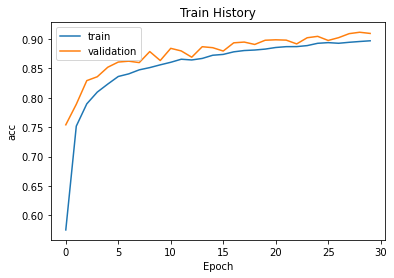

In [65]:
show_train_history(train_history_0, 'acc', 'val_acc')

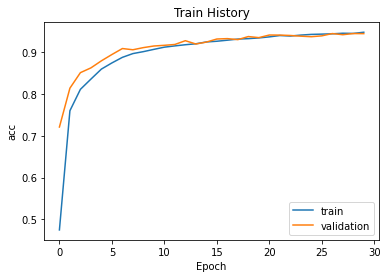

In [66]:
show_train_history(train_history_1, 'acc', 'val_acc')

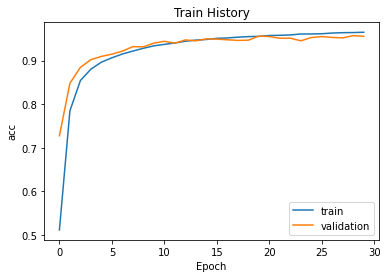

In [67]:
show_train_history(train_history_2, 'acc', 'val_acc')

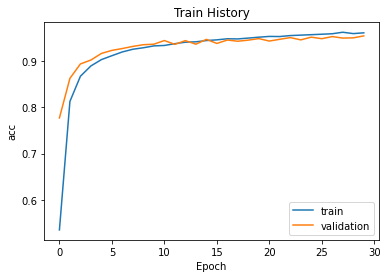

In [68]:
show_train_history(train_history_3, 'acc', 'val_acc')

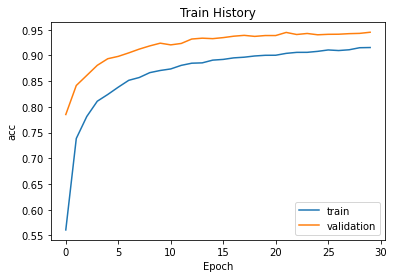

In [69]:
show_train_history(train_history_4, 'acc', 'val_acc')

In [70]:
# show_train_history(train_history_5, 'acc', 'val_acc')

In [71]:
# show_train_history(train_history_6, 'acc', 'val_acc')

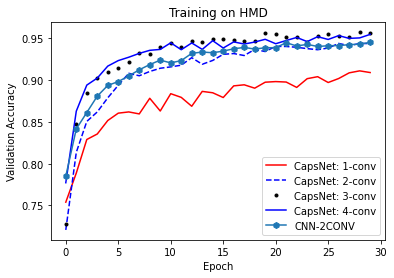

In [72]:
plt.plot(train_history_0.history['val_acc'], 'r-')
plt.plot(train_history_1.history['val_acc'], 'b--')
plt.plot(train_history_2.history['val_acc'], 'k.')
plt.plot(train_history_3.history['val_acc'], 'b-')
plt.plot(train_history_4.history['val_acc'], 'h-')
# plt.plot(train_history_5.history['val_acc'], 'c-')
# plt.plot(train_history_6.history['val_acc'], 'g*-')
# plt.plot(train_history_7.history['val_acc'], 'k-.')
plt.title('Training on HMD')
plt.ylabel('Validation Accuracy')
plt.xlabel('Epoch')
plt.legend(['CapsNet: 1-conv','CapsNet: 2-conv','CapsNet: 3-conv','CapsNet: 4-conv','CNN-2CONV'], loc='best')
plt.show()